# **Forecast number of people that uses the NYC metro:**

## Transcribing the exercise description:

### **Goal:**

The main goal is to forecast the number of people that uses the metro. You can let the imagination work and do this the way you prefer, chosing the temporal/spatial sampling rate (by station/turnstile, day/hour/week etc). This choice is part of the challenge.

### **Observation:**
Please, do not put everything in a huge ANN model directly, take a nice look at the data and perform a great exploratory data analysis. We prefer to receive the results in a notebook way, but if you wish to provide a nice script, there is no problem =) (If it's nicely commented, of course).


### **Dataset:**

Download url: https://drive.google.com/file/d/1CuE9I4x0_Agm2BMkWfnSSbiGm0-pTDuc/view?usp=sharing



---

### **Metadata:**

Fields descriptions:

- TIME = Represents the date (YYYY-MM-DD) and time (hh:mm:ss) for a scheduled audit event

- CA = Control Area (A002)

- UNIT = Remote Unit for a station (R051)

- SCP = Subunit Channel Position represents an specific address for a device (02-00-00)

- STATION = Represents the station name the device is located at

- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character. LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.

- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND

- DESC = Represent the REGULAR scheduled audit event (Normally occurs every 4 hours)
  1. Audits may occur more than 4 hours due to planning, or troubleshooting activities.
  2. Additionally, there may be a RECOVR AUD entry This refers to a missed audit that was recovered.

- ENTRIES = The comulative entry register value for a device

- EXIST = The cumulative exit register value for a device

## Beginning of the code section:

### All necessary libraries are reunited on the cell below for better organization:

In [ ]:
# libraries to read and unzip files:
import gzip
import zipfile as zf
from google.colab import drive

# library to run things in parallel:
from multiprocessing import Pool

# libraries for basic data manipulation:
import numpy as np
import pandas as pd

# libraries to make plots and visualizations:
import seaborn as sns
import matplotlib.pyplot as plt

# libraries to extract and manipulate data from APIs:
import json
import requests

# libraries to work with dates and times:
import time
import calendar
import datetime as dt

# libraries related to Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

### All necessary functions created are declared on the cell below:

In [ ]:
# function to read and unzip the file for a given year:
def read_file(year, dataset_path='/content/drive/MyDrive/Data Science/NYC Subway Dataset'):
    """
    Function to read and unzip the file for a given year

    This function was based on the content of this article:
    https://python.plainenglish.io/pandas-and-multiprocessing-how-to-create-dataframes-in-a-parallel-way-72f9b18ea72f

    Parameters:
    year (str): year of the file wanted to be read and unzipped

    Returns:
    dataframe: content of the file unzipped
    """

    with gzip.open('{}/{}.csv.gz'.format(dataset_path, year), 'rb') as gz_file:
        df = pd.read_csv(gz_file)

        # removing the rows with columns 'entries' and 'exits' with null value, because it is not useful without the numerical columns:
        df.dropna(subset=['entries', 'exits'], axis=0, inplace=True)

        print('File from year: {} / Shape: {}'.format(year, df.shape))

    return df

# function to calculate the difference between current and previous value for the given column:
def calculate_diff_values(df_device, column_name):
    """
    Function to calculate the difference between current and previous value for the given column

    Parameters:
    df_device (dataframe): data of an unique device and already sorted by time
    column_name (str): name of the needed column (entries or exits)

    Returns:
    dataframe: same input dataframe with a new column with the calculated difference

    """

    diff_column_name = '{}_diff'.format(column_name)
    df_device[diff_column_name] = df_device[column_name] - df_device[column_name].shift(1)

    return df_device


### 1 - Obtaining the dataset to use on the rest of the code:

- Connect the [url to the dataset](https://drive.google.com/file/d/1CuE9I4x0_Agm2BMkWfnSSbiGm0-pTDuc/view?usp=sharing) to the environment I am using (Google Colab);
- Unzip the .zip file and then the .gz files;
- Merge all the files in one dataframe.

In [ ]:
# I have added a shortcut from the dataset url to my Google Drive,
# so I mount my google drive to be accessible here on this notebook:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path where the shortcut to the dataset is located:
dataset_path = '/content/drive/MyDrive/Data Science/NYC Subway Dataset'

# reading the zip file containing multiple files from the dataset:
zip_file = zf.ZipFile('{}/dados_desafio.zip'.format(dataset_path))

# unziping the zip file and saving the .gz files on the same folder:
zip_file.extractall(path=dataset_path)

In [ ]:
# unziping all .gz files and adding all of them in one dataframe:

# obs.: using the data from 2016 to 2017 (ignoring from 2010 to 2015), due to not enough memory on the environment I am using to save all years:
years = [year for year in range(2016, 2018, 1)]

# creating the pool:
process_pool = Pool(processes=2)

start = time.time()

# Start processes in the pool
df_results = process_pool.map(read_file, years)

# Concat dataframes to one dataframe
df = pd.concat(df_results, ignore_index=True)

end = time.time()

print('Shape of the final dataframe: {}'.format(df.shape))
print('Completed in: %s sec'%(end - start))

# there are ~38 million rows on this dataframe (from 2014 to 2017)!!
# there are ~17 million rows on this dataframe (from 2016 to 2017)!!

File from year: 2017 / Shape: (7466025, 10)
File from year: 2016 / Shape: (10130791, 10)
Shape of the final dataframe: (17596816, 10)
Completed in: 45.675742387771606 sec


In [ ]:
# checking if the content of the dataframe is as expected:
df.sample(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
7534073,2016-09-28 13:00:00,N001,R173,01-06-02,INWOOD-207 ST,A,IND,REGULAR,428256.0,340256.0
4851998,2016-06-23 08:00:00,A025,R023,01-00-03,34 ST-HERALD SQ,BDFMNQR,BMT,REGULAR,4686179.0,1147331.0
10883476,2017-01-28 01:00:00,N333B,R141,02-00-03,FOREST HILLS 71,EFMR,IND,REGULAR,6775085.0,413624.0
17335223,2017-09-13 21:00:00,N208,R443,01-00-00,170 ST,BD,IND,REGULAR,134802.0,54582.0
15326332,2017-07-04 21:00:00,R523,R147,00-00-02,61 ST WOODSIDE,7,IRT,REGULAR,6576552.0,11374110.0
4176036,2016-05-29 21:00:00,N333A,R141,00-00-03,FOREST HILLS 71,EFMR,IND,REGULAR,515789.0,123887.0
1240193,2016-02-14 13:00:00,B027,R136,00-00-04,SHEEPSHEAD BAY,BQ,BMT,REGULAR,9698703.0,6582242.0
8640006,2016-11-07 20:00:00,N191,R335,00-00-01,BEACH 67 ST,A,IND,REGULAR,3437927.0,3667249.0
9028533,2016-11-22 00:00:00,B021,R228,00-04-01,AVENUE J,BQ,BMT,REGULAR,10.0,104.0
14363680,2017-05-31 18:00:00,N304,R015,01-06-01,5 AV/53 ST,EM,IND,REGULAR,2731771.0,2569940.0


### 2 - Preparing the dataset:

- Check for missing values;
- Adjust the data types of each column, if necessary;


In [ ]:
##################################################
# NO MISSING VALUES FROM 2016 TO 2017!!!
# PLEASE IGNORE THIS CELL!!!
# MAINTAINED HERE FOR INFORMATIONAL PURPOSE ONLY!!
##################################################

# checking if there are some missing values:
#df['station'].isnull().sum() # 160535 missing values for station (for a bigger dataset, with more years)
#df['linename'].isnull().sum() # 160535 missing values for linename (for a bigger dataset, with more years)
#df['division'].isnull().sum() # 160535 missing values for division (for a bigger dataset, with more years)

#num_missing = np.round(160535/17596816 * 100, 2)

#print('Only {}% of rows with missing values, so I decided to remove them!'.format(num_missing))

#df.dropna(subset=['station', 'linename', 'division'], axis=0, inplace=True)
#print(df.shape)

0

In [ ]:
# what are the best data types for each column?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17596816 entries, 0 to 17596815
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
dtypes: float64(2), object(8)
memory usage: 1.3+ GB


In [ ]:
# forcing the quantitative variables to a integer number:
# obs: when I tried to make this castings,
# I ran out of memory on Google Colab, so I did not change to integer (not so essencial to the rest of the code)

#df['entries'] = df['entries'].astype(int)
#df['exits'] = df['exits'].astype(int)

# changing the date variable to timestamp type:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# checking the data types again to make sure the data type adjustments worked:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17596816 entries, 0 to 17596815
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        object        
 2   unit      object        
 3   scp       object        
 4   station   object        
 5   linename  object        
 6   division  object        
 7   desc      object        
 8   entries   float64       
 9   exits     float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 1.3+ GB


In [ ]:
# creating new columns related to date and time:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

df['week_day'] = df['time'].dt.dayofweek
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour

df.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,day,week_day,date,hour
0,2016-01-01,A002,R051,02-00-00,59 ST,NQR456,BMT,REGULAR,5477257.0,1848890.0,2016,1,1,4,2016-01-01,0
1,2016-01-01,A002,R051,02-00-01,59 ST,NQR456,BMT,REGULAR,5043156.0,1101348.0,2016,1,1,4,2016-01-01,0
2,2016-01-01,A002,R051,02-03-00,59 ST,NQR456,BMT,REGULAR,624029.0,2352788.0,2016,1,1,4,2016-01-01,0
3,2016-01-01,A002,R051,02-03-01,59 ST,NQR456,BMT,REGULAR,5006519.0,7904628.0,2016,1,1,4,2016-01-01,0
4,2016-01-01,A002,R051,02-03-02,59 ST,NQR456,BMT,REGULAR,4734413.0,6529179.0,2016,1,1,4,2016-01-01,0


### 3 - Exploratory Data Analysis (EDA)

#### 3.1 - Checking the categorical variables:

In [ ]:
# checking cardinality of each categorical variable:
df['ca'].value_counts(dropna=False)

# 737 different Control Areas
# How to use this variable on a model??

PTH05    93005
R610     87532
PTH16    79741
PTH07    77613
A046     73833
         ...  
OB01      7584
J022      7574
R630      7446
PTH21     6950
A085      3781
Name: ca, Length: 737, dtype: int64

In [ ]:
# checking cardinality of each categorical variable:
df['unit'].value_counts(dropna=False)

# 470 different Units
# How to use this variable on a model??

R549    235396
R014    191484
R057    186826
R084    157618
R550    157354
         ...  
R349      7731
R397      7597
R459      7584
R435      7574
R066      7446
Name: unit, Length: 470, dtype: int64

In [ ]:
df['scp'].value_counts(dropna=False)

# 237 different Subunit Channel Position
# How to use this variable on a model??

00-00-00    1749290
00-00-01    1739658
00-00-02    1572589
00-00-03     747594
00-03-00     574976
             ...   
00-FF-01          1
00-00-26          1
00-00-C7          1
02-10-05          1
00-12-00          1
Name: scp, Length: 237, dtype: int64

In [ ]:
df['station'].value_counts(dropna=False)

# 380 different Stations
# How to use this variable on a model??

34 ST-PENN STA     378862
FULTON ST          366628
23 ST              270598
GRD CNTRL-42 ST    239895
CANAL ST           223186
                    ...  
SUTTER AV            7731
ORCHARD BEACH        7584
CLEVELAND ST         7574
JUNIUS ST            7446
PATH WTC 2           6950
Name: station, Length: 380, dtype: int64

In [ ]:
df['linename'].value_counts(dropna=False)

# 128 different combination of Line Names
# How to use this variable on a model??
# Maybe split each line that can be boarded on some station on separate columns?!?

1              2025763
6              1068332
7               806114
F               652973
25              594605
                ...   
ACENGRS1237      16649
23ACE            15269
S2345            15208
7NQW             11905
7NQ              10933
Name: linename, Length: 128, dtype: int64

In [ ]:
df['division'].value_counts(dropna=False)

# 6 different Divisions
# How to use this variable on a model??
# Create dummies for each category!! :)

IRT    6453634
IND    6264533
BMT    3696600
PTH    1018047
SRT     127630
RIT      36372
Name: division, dtype: int64

In [ ]:
df['desc'].value_counts(dropna=False)

# 2 different Scheduled Audit Events
# How to use this variable on a model??
# Create dummies for each category!!
# Also, try to understand the meaning of each category!!
# Maybe consider only the REGULAR audit events

REGULAR       17524885
RECOVR AUD       71931
Name: desc, dtype: int64

In [ ]:
# using only the regular audit events:
df = df.query("desc == 'REGULAR' ")
df.shape

(17524885, 16)

#### 3.2 - Checking the numerical variables:

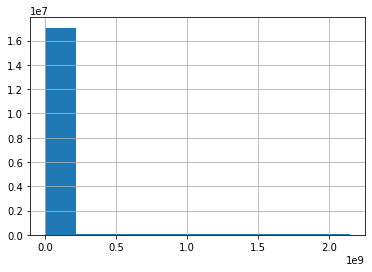

In [ ]:
df['entries'].hist();

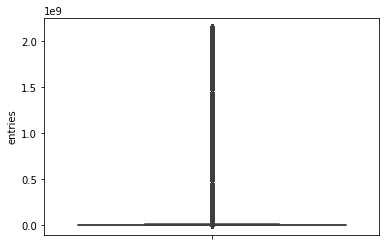

In [ ]:
sns.boxplot(data=df, y='entries');

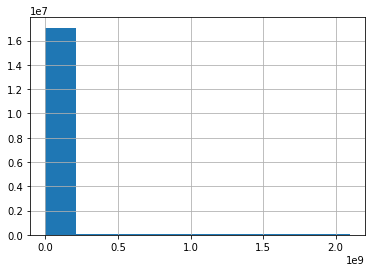

In [ ]:
df['exits'].hist();

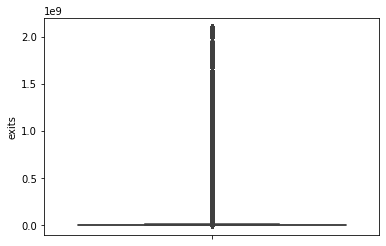

In [ ]:
sns.boxplot(data=df, y='exits');

👀 **Observations:**
The entries and exits values do not mean anything when checking the **histogram** and the **boxplot**, because they are cumulative values for each device (turnstile)!!

💡
So, I will calculate the value of entries and exits for each device between an audit event and the next one and create new columns on the dataframe!!

❓  What identifies an unique device?

✅ I will assume that the combination of unique ca, unit and scp represents a device!!

#### 3.3 - Formatting the data before continuing the EDA:

In [ ]:
# so, for each device, I will calculate the difference of entries
# from one audit event to the previous one and save it:

df_unique_devices = df[['ca', 'unit', 'scp']].drop_duplicates(inplace=False, ignore_index=True)
df_unique_devices.shape

# Considering the assumptions above, there are 4819 differente devices!!

(4819, 3)

In [ ]:
df_unique_devices.sort_values(by=['ca', 'unit', 'scp'])

,ca,unit,scp
0,A002,R051,02-00-00
1,A002,R051,02-00-01
2,A002,R051,02-03-00
3,A002,R051,02-03-01
4,A002,R051,02-03-02
...,...,...,...
4163,TRAM2,R469,00-00-01
4164,TRAM2,R469,00-03-00
4165,TRAM2,R469,00-03-01
4166,TRAM2,R469,00-05-00


In [ ]:
# loop to separate each device, sort by time and apply the function I created to calculate the diff values:

df_total = pd.DataFrame()

# using only 500 random devices, because with the time I got, I could not make it run with the memory I had for all devices:
df_temp = df_unique_devices.sample(500, ignore_index=True)
num_devices = df_temp.shape[0]

for idx, row in df_temp.iterrows():
    ca = row['ca']
    unit = row['unit']
    scp = row['scp']
    df_device = df.query("ca == '{}' and unit == '{}' and scp == '{}' ".format(ca, unit, scp))
    df_device = df_device.sort_values(by=['time'])

    # the function 'calculate_diff_values' are available on the 'functions section':
    df_device = calculate_diff_values(df_device, 'entries')
    df_device = calculate_diff_values(df_device, 'exits')

    print('{}/{} - Device --> ca: {} / unit: {} / scp: {} --> Shape: {}'.format(idx+1, num_devices, ca, unit, scp, df_device.shape))

    df_total = pd.concat([df_total, df_device], axis=0, ignore_index=True)

print('')
print('Shape of the dataframe combining all devices again: {}'.format(df_total.shape))

1/500 - Device --> ca: R169 / unit: R168 / scp: 01-00-04 --> Shape: (3784, 18)
2/500 - Device --> ca: R202 / unit: R042 / scp: 00-00-01 --> Shape: (3451, 18)
3/500 - Device --> ca: R402 / unit: R446 / scp: 00-00-03 --> Shape: (3817, 18)
4/500 - Device --> ca: R515 / unit: R095 / scp: 00-03-00 --> Shape: (3832, 18)
5/500 - Device --> ca: N078 / unit: R175 / scp: 01-03-00 --> Shape: (3805, 18)
6/500 - Device --> ca: PTH08 / unit: R540 / scp: 00-00-06 --> Shape: (1019, 18)
7/500 - Device --> ca: PTH03 / unit: R552 / scp: 00-00-00 --> Shape: (3489, 18)
8/500 - Device --> ca: E001 / unit: R368 / scp: 00-00-01 --> Shape: (3872, 18)
9/500 - Device --> ca: R201 / unit: R041 / scp: 00-05-00 --> Shape: (3767, 18)
10/500 - Device --> ca: R158 / unit: R084 / scp: 00-00-01 --> Shape: (3824, 18)
11/500 - Device --> ca: N012 / unit: R035 / scp: 01-06-01 --> Shape: (3826, 18)
12/500 - Device --> ca: PTH11 / unit: R545 / scp: 00-00-00 --> Shape: (3598, 18)
13/500 - Device --> ca: N094 / unit: R029 / sc

In [ ]:
# saving this partial result to be reused and avoid having to run the above cell again:
df_total.to_csv('/content/drive/MyDrive/Data Science/NYC Subway Dataset/df_total_devices.csv')

In [ ]:
# checking if the calculations are correct:
# taking some random device:
random_device = df_temp.sample(1)
ca = random_device['ca'].item()
unit = random_device['unit'].item()
scp = random_device['scp'].item()
print('Device chosen at random --> ca: {} / unit: {} / scp: {}'.format(ca, unit, scp))

df_some_device = df_total.query("ca == '{}' and unit == '{}' and scp == '{}' ".format(ca, unit, scp)).sort_values('time')
df_some_device

# YES!! The calculations seem to be correct!!

Random device chosen --> ca: B009 / unit: R411 / scp: 00-00-02


,time,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,day,week_day,date,hour,entries_diff,exits_diff
1805832,2016-01-01 01:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3577468.0,4262541.0,2016,1,1,4,2016-01-01,1,NaN,NaN
1805833,2016-01-01 05:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3577580.0,4262654.0,2016,1,1,4,2016-01-01,5,112.0,113.0
1805834,2016-01-01 09:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3577609.0,4262732.0,2016,1,1,4,2016-01-01,9,29.0,78.0
1805835,2016-01-01 13:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3577637.0,4262769.0,2016,1,1,4,2016-01-01,13,28.0,37.0
1805836,2016-01-01 17:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3577681.0,4262805.0,2016,1,1,4,2016-01-01,17,44.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809636,2017-09-22 09:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3926177.0,4687009.0,2017,9,22,4,2017-09-22,9,3.0,10.0
1809637,2017-09-22 13:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3926311.0,4687119.0,2017,9,22,4,2017-09-22,13,134.0,110.0
1809638,2017-09-22 17:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3926425.0,4687209.0,2017,9,22,4,2017-09-22,17,114.0,90.0
1809639,2017-09-22 21:00:00,B009,R411,00-00-02,PARK PLACE,S,BMT,REGULAR,3926550.0,4687381.0,2017,9,22,4,2017-09-22,21,125.0,172.0


In [ ]:
# checking how many rows with null values, since the first one for each device shouold be null now:
df_total.isnull().sum()

# as expected, one row per device has the entries_diff and exits_diff values as NaN!!

time              0
ca                0
unit              0
scp               0
station           0
linename          0
division          0
desc              0
entries           0
exits             0
year              0
month             0
day               0
week_day          0
date              0
hour              0
entries_diff    500
exits_diff      500
dtype: int64

In [ ]:
# removing the NaN values:
df_total.dropna(axis=0, inplace=True)
df_total.shape

(1832157, 18)

#### 3.4 - Continuing the bivariate analysis:

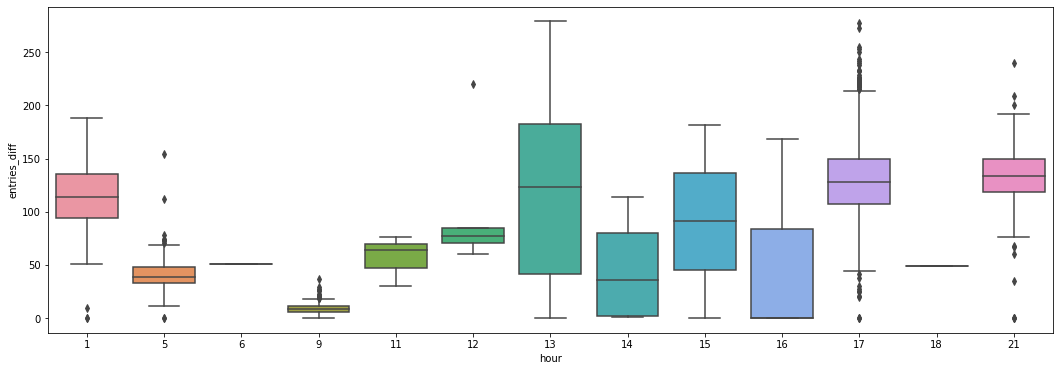

In [ ]:
# continuing with the analysis of the device chosen at random:
# how is the behaviour of entries and exits for a specific device?
plt.figure(figsize=(18,6));
sns.boxplot(data=df_some_device, x='hour', y='entries_diff');
plt.show()

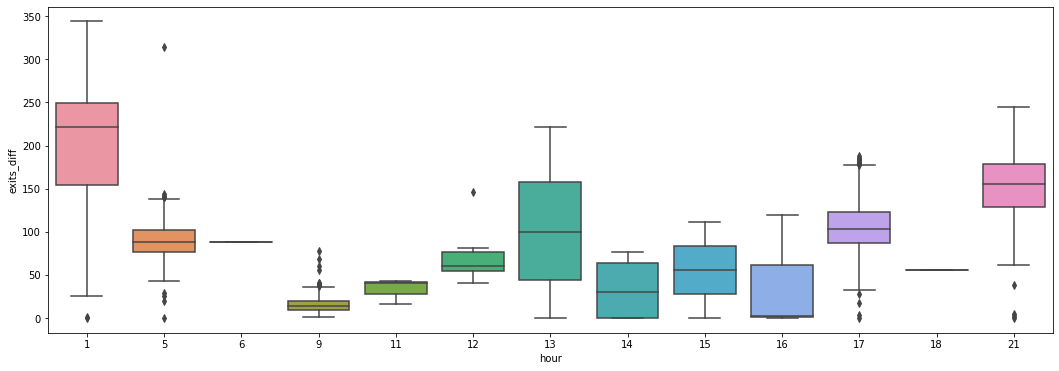

In [ ]:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_some_device, x='hour', y='exits_diff');
plt.show()

# as expected, the volume of entries and exits changes depending on the hour of the day for this device!!
# the same behaviour must be true for all devices!!

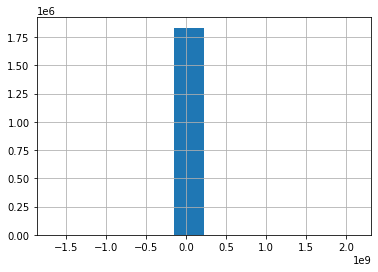

In [ ]:
# now, back to the all the devices:
# checking again the histogram and boxplot, but now with the diff values:
df_total['entries_diff'].hist();

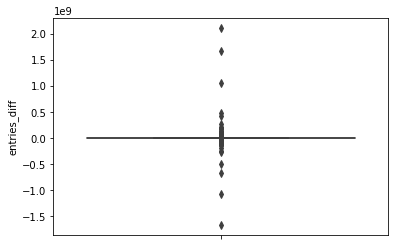

In [ ]:
sns.boxplot(data=df_total, y='entries_diff');

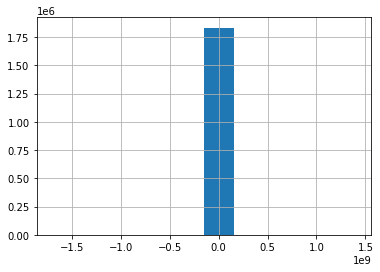

In [ ]:
# the same for the exits_diff:
df_total['exits_diff'].hist();

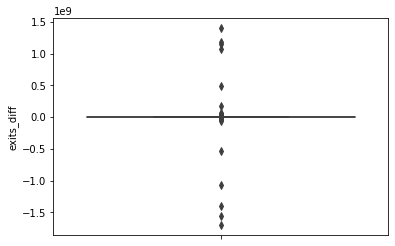

In [ ]:
sns.boxplot(data=df_total, y='exits_diff');

In [ ]:
# checking the values for the main quartiles:
df_total[['entries_diff', 'exits_diff']].describe()

,entries_diff,exits_diff
count,1.832157e+06,1.832157e+06
mean,1.724359e+03,-2.578581e+02
std,2.777024e+06,2.847081e+06
min,-1.676253e+09,-1.703784e+09
25%,1.100000e+01,7.000000e+00
50%,7.800000e+01,4.700000e+01
75%,2.460000e+02,1.530000e+02
max,2.122193e+09,1.405714e+09


In [ ]:
# there are some negative values (which should not exist because the original values were cumulative):
df_total.query("entries_diff < 0 or exits_diff < 0").shape

# a lot of rows with negative values, so maybe I will turn them into positive values:
# cumulative in the other direction?!?!?!?

(16448, 18)

In [ ]:
# absolute values for all entries and exits:
df_total['entries_diff'] = np.abs(df_total['entries_diff'])
df_total['exits_diff'] = np.abs(df_total['exits_diff'])
df_total.shape

(1832157, 18)

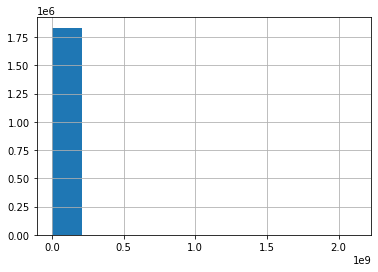

In [ ]:
# checking every plot again:

# histogram:
df_total['entries_diff'].hist();

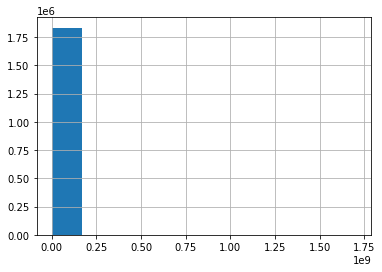

In [ ]:
df_total['exits_diff'].hist();

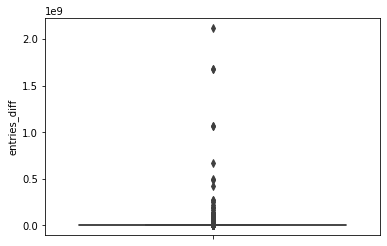

In [ ]:
sns.boxplot(data=df_total, y='entries_diff');

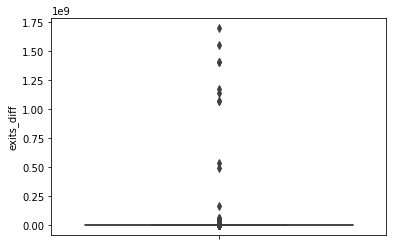

In [ ]:
sns.boxplot(data=df_total, y='exits_diff');

In [ ]:
# checking the new values for the main quartiles:
df_total[['entries_diff', 'exits_diff']].describe()

,entries_diff,exits_diff
count,1.832157e+06,1.832157e+06
mean,7.961834e+03,7.002526e+03
std,2.777013e+06,2.847073e+06
min,0.000000e+00,0.000000e+00
25%,1.200000e+01,8.000000e+00
50%,8.000000e+01,4.900000e+01
75%,2.490000e+02,1.580000e+02
max,2.122193e+09,1.703784e+09


In [ ]:
# checking how many very high values, because they seem to be wrong:

threshold_entries = np.nanquantile(df_total['entries_diff'], 0.999)
threshold_exits = np.nanquantile(df_total['exits_diff'], 0.999)
print(threshold_entries)
print(threshold_exits)

# checking how many rows above the thresholds:
print(df_total.query("entries_diff >= {}".format(threshold_entries)).shape)
print(df_total.query("exits_diff >= {}".format(threshold_exits)).shape)

1968.0
1835.6470000001136
(1831, 18)
(1829, 18)


In [ ]:
some_device_with_extreme_values = df_total.query("entries_diff >= {}".format(threshold_entries)).sample(1)
some_device_with_extreme_values

,time,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,day,week_day,date,hour,entries_diff,exits_diff
1680737,2017-05-03 01:00:00,R240,R047,00-03-07,GRD CNTRL-42 ST,4567S,IRT,REGULAR,4760169.0,1452052.0,2017,5,3,2,2017-05-03,1,2553.0,87.0


Device chosen at random --> ca: R240 / unit: R047 / scp: 00-03-07


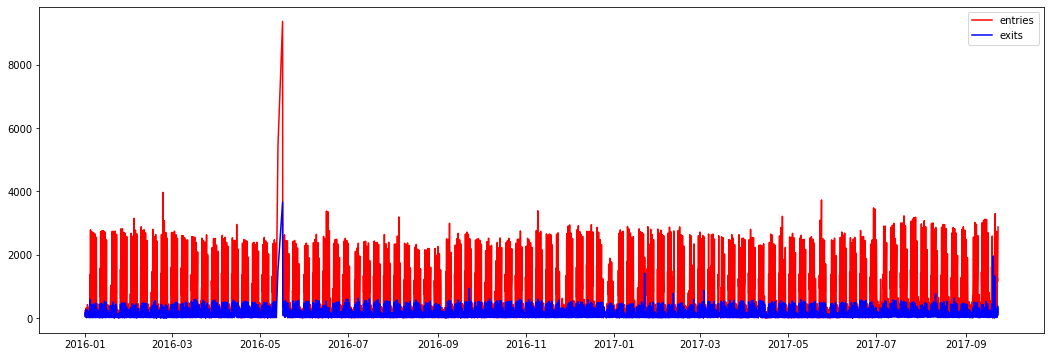

In [ ]:
# checking some of the devices with very high values:
ca = some_device_with_extreme_values['ca'].item()
unit = some_device_with_extreme_values['unit'].item()
scp = some_device_with_extreme_values['scp'].item()
print('Device chosen at random --> ca: {} / unit: {} / scp: {}'.format(ca, unit, scp))

df_another_device = df_total.query("ca == '{}' and unit == '{}' and scp == '{}' ".format(ca, unit, scp)).sort_values('time')

plt.figure(figsize=(18,6));

plt.plot(df_another_device['time'], df_another_device['entries_diff'], c='r', label='entries');
plt.plot(df_another_device['time'], df_another_device['exits_diff'], c='b', label='exits');

plt.legend()
plt.show()

# absolutely, an error!! I will remove this extreme values!!

In [ ]:
# removing rows with entries above the percentile 99.9 calculated above:
df_total = df_total.query("entries_diff < {}".format(threshold_entries))
df_total = df_total.query("exits_diff < {}".format(threshold_exits))
df_total.shape

(1828354, 18)

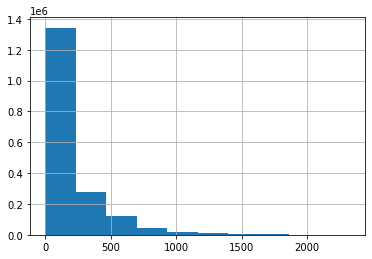

In [ ]:
# checking every plot again again:

# histogram:
df_total['entries_diff'].hist();

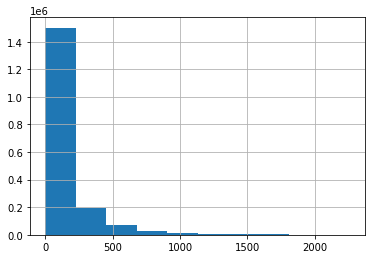

In [ ]:
df_total['exits_diff'].hist();

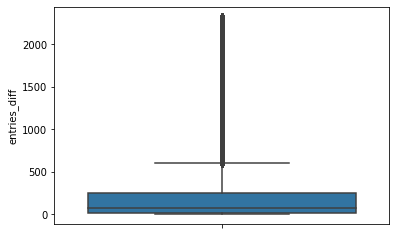

In [ ]:
sns.boxplot(data=df_total, y='entries_diff');

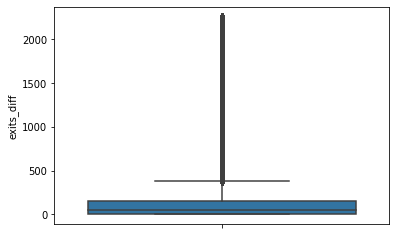

In [ ]:
sns.boxplot(data=df_total, y='exits_diff');

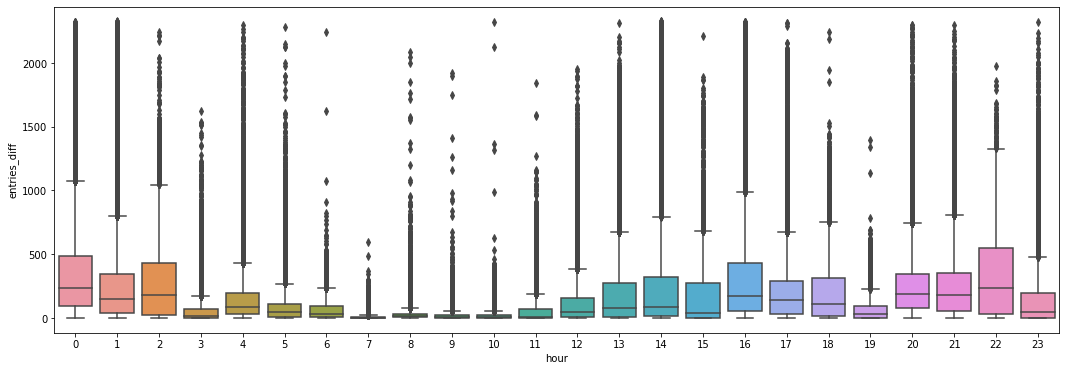

In [ ]:
# checking the distribution of entries and exits per hour:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='hour', y='entries_diff');
plt.show()

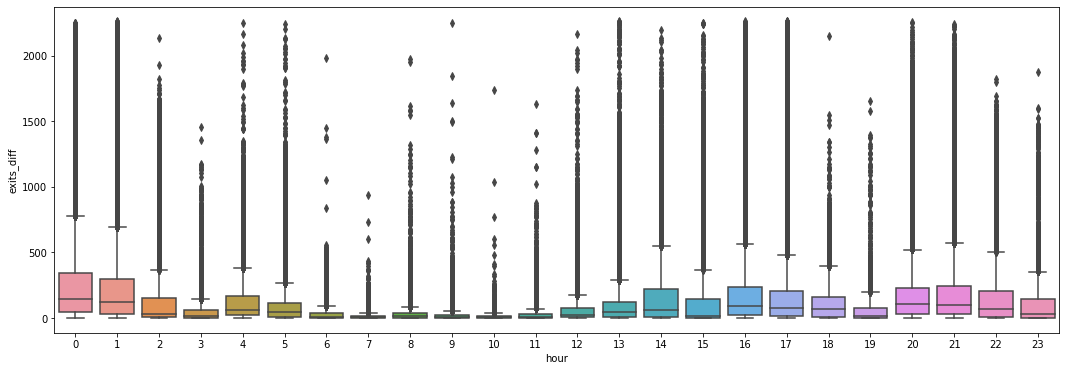

In [ ]:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='hour', y='exits_diff');
plt.show()

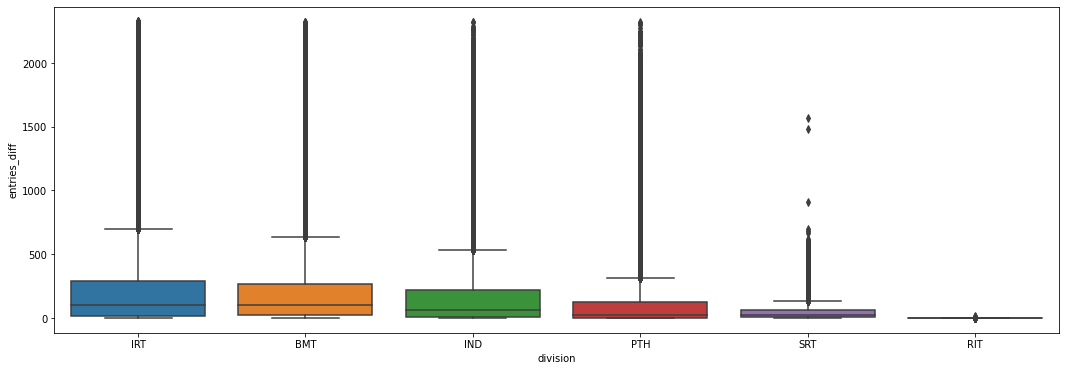

In [ ]:
# checking the distribution of entries and exits per division:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='division', y='entries_diff');
plt.show()

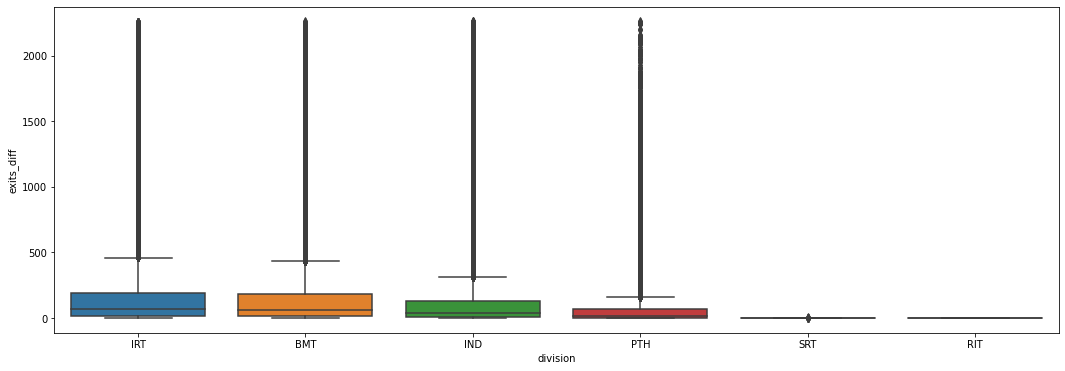

In [ ]:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='division', y='exits_diff');
plt.show()

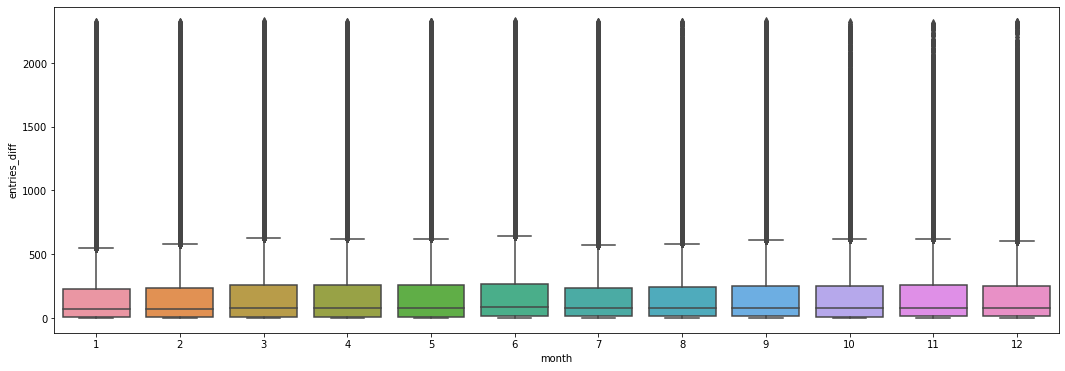

In [ ]:
# checking the distribution of entries and exits per month:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='month', y='entries_diff');
plt.show()

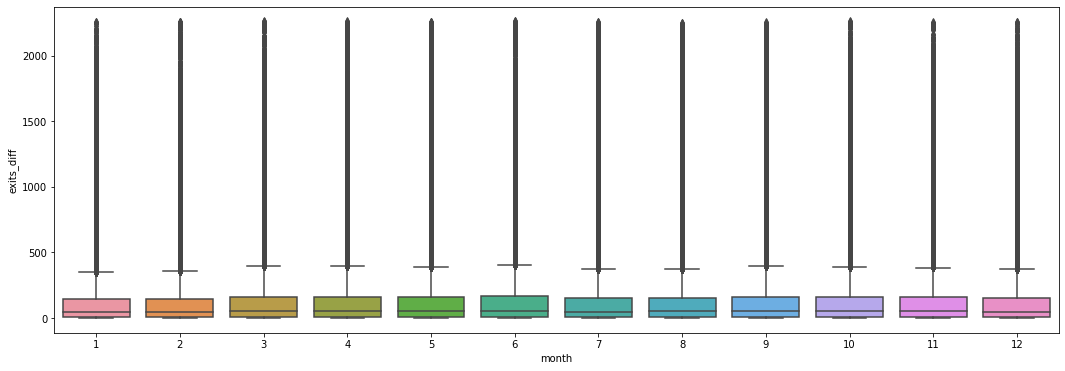

In [ ]:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='month', y='exits_diff');
plt.show()

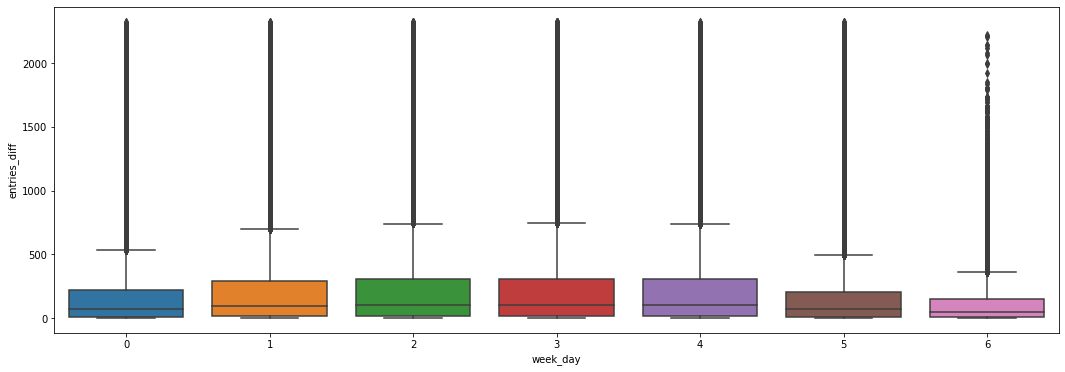

In [ ]:
# checking the distribution of entries and exits per day of week:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='week_day', y='entries_diff');
plt.show()

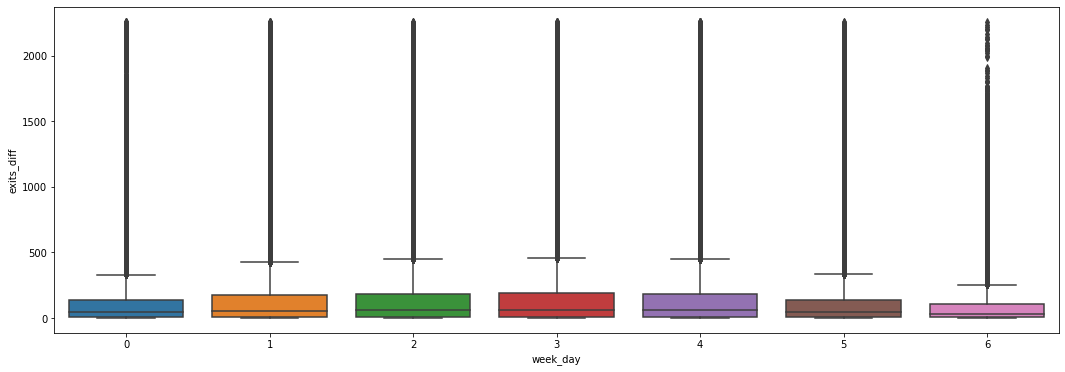

In [ ]:
plt.figure(figsize=(18,6));
sns.boxplot(data=df_total, x='week_day', y='exits_diff');
plt.show()

In [ ]:
# checking how many different line names there are (split the characters of the column linename):
linename_list = df_total['linename'].unique().tolist()
linename_list[:10]

['123', '45', '6', 'NQ', 'NQW', 'ACEL', '1', 'D', '1ABCD', 'AC1']

In [ ]:
linename_chars = [list(name) for name in linename_list]
linename_chars[:10]

[['1', '2', '3'],
 ['4', '5'],
 ['6'],
 ['N', 'Q'],
 ['N', 'Q', 'W'],
 ['A', 'C', 'E', 'L'],
 ['1'],
 ['D'],
 ['1', 'A', 'B', 'C', 'D'],
 ['A', 'C', '1']]

In [ ]:
chars_list = [char for sublist in linename_chars for char in sublist]
chars_list = list(set(chars_list))
print(len(chars_list))
print(chars_list)

# due to lack of time, I was not able to continue this, but the idea was to create dummy variables for each of the 23 different train lines!! :(

23
['Q', 'R', '2', '7', 'E', 'F', 'C', 'D', 'L', 'A', 'M', 'G', 'J', 'S', '1', '5', 'W', 'B', '3', 'N', '4', '6', 'Z']


Insights from the EDA:

- I will not use to train the model the categorical variables with high cardinality:
  1. ca, unit and scp: but they were used to identifiy each device, so it helped in a way;
  2. station: because there are almost 400 different stations;
  3. desc: because it is just a metadata about the audit event, not about the event itself.


- Features that will be used to train the model:
  1. division: I created dummy variables for this column;
  2. day;
  3. month;
  4. hour;
  5. weekday.

- What else could be used, but due to lack of time, I did not include:
  1. past values for each event of each device:
    - value for the previous hour;
    - average value for the previous 24 hours;
    - moving averages for different intervals.
  2. some category of the stations, such as if it is a low, medium or high volume station (that way, the station would be used in some way);
  3. dummy variables representing each train line that can boarded at each station


- I will combine the values of **entries_diff** and **exits_diff** in one column, since the goal is to forecast the number of people that uses the metro, so this means both the ones that enters and the ones that leaves the metro.

In [ ]:
# creating just one target variable:
df_total['num_passengers'] = df_total['entries_diff'] + df_total['exits_diff']
df_total.sample(3)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,day,week_day,date,hour,entries_diff,exits_diff,BMT,IND,IRT,PTH,RIT,SRT,num_passengers
39095,2016-04-16 15:30:08,PTH11,R545,00-00-00,14TH STREET,1,PTH,REGULAR,1.660800e+04,833.0,2016,4,16,5,2016-04-16,15,49.0,10.0,0,0,0,1,0,0,59.0
401626,2016-06-14 21:00:00,R303,R324,00-00-01,116 ST,23,IRT,REGULAR,4.817626e+06,3187922.0,2016,6,14,1,2016-06-14,21,286.0,177.0,0,0,1,0,0,0,463.0
1489508,2017-05-06 16:00:00,R245,R051,00-03-02,59 ST,456NQRW,IRT,REGULAR,1.040529e+09,736819328.0,2017,5,6,5,2017-05-06,16,0.0,192.0,0,0,1,0,0,0,192.0


In [ ]:
df_total['num_passengers'].describe()

count    1.828354e+06
mean     3.137152e+02
std      3.873673e+02
min      0.000000e+00
25%      3.400000e+01
50%      1.740000e+02
75%      4.560000e+02
max      4.421000e+03
Name: num_passengers, dtype: float64

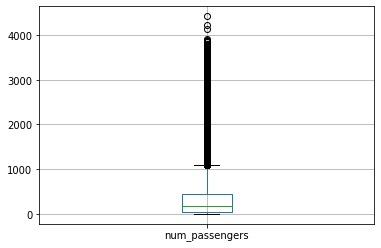

In [ ]:
df_total[['num_passengers']].boxplot();

In [ ]:
# removing extreme values from the 'num_passengers' variable:
threshold = np.nanquantile(df_total['num_passengers'], 0.999)

print(threshold)
print(df_total.query("num_passengers >= {}".format(threshold)).shape)

df_total = df_total.query("num_passengers < {}".format(threshold))
df_total.shape

2610.0
(1830, 25)


(1826524, 25)

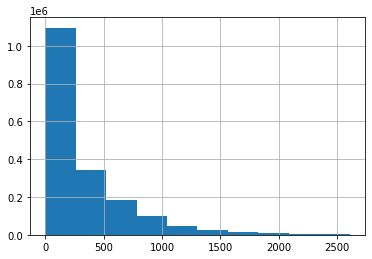

In [ ]:
df_total['num_passengers'].hist(bins=10);

In [ ]:
# picking a device at random:
random_device = df_total.sample(1)
ca = random_device['ca'].item()
unit = random_device['unit'].item()
scp = random_device['scp'].item()

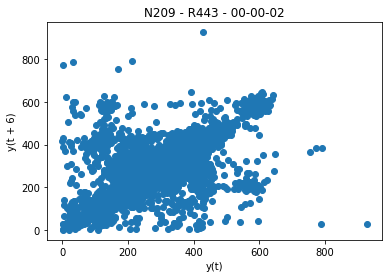

In [ ]:
# analysing a lag plot, but due to lack of time, I did not continue with this idea of checking auto-correlation:

# trying some values for the lag:
lag_value = 6
pd.plotting.lag_plot(df_total.query("ca == '{}' and unit == '{}' and scp == '{}' ".format(ca, unit, scp))['num_passengers'], lag=lag_value);
plt.title('{} - {} - {}'.format(ca, unit, scp));
plt.show()

# the idea of this plot is that the more similar to a 45º line (diagonal) this chart, the more auto-correlated the num_passengers is
# which means that the value for some time could be high or low correlated with the value of the previous time following the lag chosen!!

# not using this for the model, though... :(

### 4 - Preprocessing the dataset:

#### 4.1 - Creating the dummy variables:

In [ ]:
# creating dummy variables for the categorical variable 'division':
df_total[['BMT', 'IND', 'IRT', 'PTH', 'RIT', 'SRT']] = pd.get_dummies(df_total['division'])
df_total.sample(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,year,month,day,week_day,date,hour,entries_diff,exits_diff,BMT,IND,IRT,PTH,RIT,SRT,num_passengers
778607,2017-05-25 13:00:00,N318,R298,00-00-02,NORTHERN BLVD,MR,IND,REGULAR,2325012.0,419113.0,2017,5,25,3,2017-05-25,13,1247.0,36.0,0,1,0,0,0,0,1283.0
1737088,2017-07-16 12:00:00,N605,R024,00-06-03,SUTPHIN-ARCHER,EJZ,IND,REGULAR,69447456.0,20852538.0,2017,7,16,6,2017-07-16,12,96.0,70.0,0,1,0,0,0,0,166.0
1625027,2017-01-20 21:00:00,G001,R151,00-00-04,CONEY IS-STILLW,DFNQ,BMT,REGULAR,2994845.0,2139363.0,2017,1,20,4,2017-01-20,21,99.0,60.0,1,0,0,0,0,0,159.0
1621821,2017-04-29 00:00:00,N070,R012,04-05-01,34 ST-PENN STA,ACE,IND,REGULAR,117440512.0,244.0,2017,4,29,5,2017-04-29,0,0.0,0.0,0,1,0,0,0,0,0.0
780551,2016-07-06 22:00:00,R203,R043,00-00-00,WALL ST,45,IRT,REGULAR,1802274.0,754880.0,2016,7,6,2,2016-07-06,22,696.0,86.0,0,0,1,0,0,0,782.0


#### 4.2 - Spliting the dataset in train, validation and test sets:

In [ ]:
# splitting the dataset to be able to evaluate the performance of the models:

# considering only the variables that will be used on the model:
# obs: not using 'BMT' to avoid multicolinearity between the divisions (#dummy_variables = #categories - 1):
usable_variables = ['month', 'day', 'week_day', 'hour', 'IND', 'IRT', 'PTH', 'RIT', 'SRT']
X = df_total[usable_variables]

# num_passengers is the target variable (y):
y = df_total['num_passengers']

# using a function from sklearn to make the split (first only in train and test):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# checking if the shape of each dataset is correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1461219, 9)
(1461219,)
(365305, 9)
(365305,)


### 5 - Model selection:

Models that could be evaluated:

- Linear Regression (not tried due to lack of time and for this to work, it is necessary to check for a lot of assumptions, make some statistical tests and so on, so I decided to skip the linear regression);
- **Decision Tree Regression;**
- **Random Forest Regression;**
- XGBoosting Regression;
- Neural Network.

The model with the best performance will be selected for the next step.

#### 5.1 - Decision Tree Regression:

In [ ]:
# Decision Tree Regression:
model_tree = DecisionTreeRegressor(random_state=42)

# doing a cross validation:
cross_val_score(model_tree, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

array([-321.73894937, -322.4339155 , -319.74728552, -320.93997569,
       -322.58612662])

In [ ]:
# training the model:
model_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

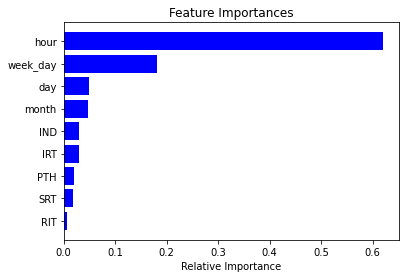

In [ ]:
# checking the importance of each variable:
features = X_train.columns
importances = model_tree.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances');
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

# using the decision tree just to be able to understand the importance of each variable...

#### 5.2 - Random Forest Regression:

In [ ]:
# Random Forest Regression:
model_forest = RandomForestRegressor(random_state=42)

# doing a cross validation:
cross_val_score(model_forest, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')

array([-321.23895549, -319.55487509, -321.55911419])

In [ ]:
# training the model:
model_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Obs.: Due to lack of time, I will consider the Random Forest the algorithm with the best performance metric (RMSE) on the validation dataset and so I will check it on the test dataset.
(With more time, I would try some other regression algorithms and also do a grid search to fine tune the hyperparameters)

In [ ]:
# I like to compare the prediction on both train and test datasets:
y_train_pred = model_forest.predict(X_train)
y_test_pred = model_forest.predict(X_test)

In [ ]:
# combining all y values on one dataframe to make the comparison easier:
df_train = pd.DataFrame()
df_train[usable_variables] = X_train
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred


df_test = pd.DataFrame()
df_test[usable_variables] = X_test
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

print(df_train.shape)
print(df_test.shape)

(1461219, 11)
(365305, 11)


In [ ]:
# calculating the difference between the real and the predicted value and also the percentage difference for each individual row:
df_train['diff'] = np.round(np.abs(df_train['y_train'] - df_train['y_train_pred']), 2)
df_train['diff_%'] = np.round(np.abs((df_train['y_train'] - df_train['y_train_pred']) / df_train['y_train'] * 100), 2)

df_test['diff'] = np.round(np.abs(df_test['y_test'] - df_test['y_test_pred']), 2)
df_test['diff_%'] = np.round(np.abs((df_test['y_test'] - df_test['y_test_pred']) / df_test['y_test'] * 100), 2)

In [ ]:
# checking the best and worst predictions on the train dataset:
df_train.query("y_train > 0").sort_values(by=['diff'], ascending=True)

,month,day,week_day,hour,IND,IRT,PTH,RIT,SRT,y_train,y_train_pred,diff,diff_%
750814,1,9,0,10,0,0,0,0,1,2.0,2.003333,0.00,0.17
1387246,10,3,0,5,1,0,0,0,0,69.0,69.003882,0.00,0.01
749447,6,1,2,10,0,0,0,0,1,1.0,1.002857,0.00,0.29
37822,6,4,6,12,1,0,0,0,0,57.0,56.999879,0.00,0.00
357634,5,12,3,10,0,0,0,0,1,1.0,1.003333,0.00,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874854,8,16,1,4,0,0,0,0,0,2568.0,258.011203,2309.99,89.95
608324,3,12,5,13,0,1,0,0,0,2498.0,142.110604,2355.89,94.31
1244552,5,4,2,10,1,0,0,0,0,2605.0,218.832114,2386.17,91.60
509288,12,16,4,9,0,1,0,0,0,2567.0,111.377312,2455.62,95.66


In [ ]:
# checking the best and worst predictions on the test dataset:
df_test.query("y_test > 0").sort_values(by=['diff'], ascending=True)

,month,day,week_day,hour,IND,IRT,PTH,RIT,SRT,y_test,y_test_pred,diff,diff_%
478651,7,7,3,5,1,0,0,0,0,112.0,111.998205,0.00,0.00
1519869,4,29,4,9,0,1,0,0,0,32.0,32.000927,0.00,0.00
1646653,6,27,0,1,0,0,0,0,0,526.0,525.996020,0.00,0.00
65130,2,10,2,3,0,0,1,0,0,336.0,335.996531,0.00,0.00
751470,4,28,4,10,0,0,0,0,1,1.0,0.996333,0.00,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769201,9,8,3,14,1,0,0,0,0,2332.0,90.652452,2241.35,96.11
569856,10,5,2,1,1,0,0,0,0,2527.0,284.601531,2242.40,88.74
570852,3,18,5,1,1,0,0,0,0,2600.0,357.120565,2242.88,86.26
570025,11,2,2,1,1,0,0,0,0,2535.0,291.678499,2243.32,88.49


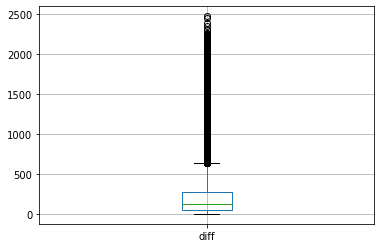

In [ ]:
# checking if the error is uniformly distributed or not:
df_train[['diff']].boxplot();

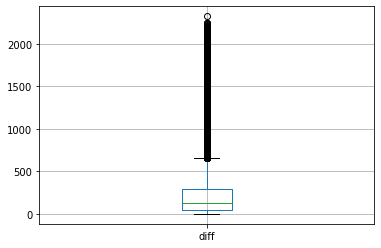

In [ ]:
# checking if the error is uniformly distributed or not:
df_test[['diff']].boxplot();

In [ ]:
# Mean error:
print('Mean error:')
print(df_train['diff'].mean())
print(df_test['diff'].mean())

print('')
# Median error:
print('Median error:')
print(df_train['diff'].median())
print(df_test['diff'].median())

Mean error:
203.08945505774795
210.3364261918165

Median error:
128.98
133.78


Insights about the model selection:

- By looking at the feature importance plot generated using the decision tree, it seems the **hour of the day** is the thing that influences the most the volume of users on some station, which makes sense, because of the different peaks of use on working hours and at night;

- The model is terrible for the high values, so it is necessary to return to the EDA step and take a better look on this, before going to the modeling step;

- With more time, it is possible to try different algorithms and also run a grid search for each to choose the best combination of hyperparameters.

### 6 - Conclusions:

- Using the Random Forest, it was possible to forecast the number of users on a specific hour of the day, for a given month, weekday and which division the station belongs to, with an average error of 200 users;
- The model is not good for the extreme high values. This is something that needs further investigation (this outliers are valid values or are something wrong with the data?!?);
- Also, to pick the best combination of hyperparameters for each model, it is important to try different combinations and evaluate on a separete validation set, beforing evaluating the final chosen combination on the test set;
- I chose to model in a way that the forecasts are on the level of device and per hour. I started analysing the behaviour of the data when grouping things by day and station, but I prefer to not include here, because it would be a whole different analysis and results;
- When the model is good enough and are able to forecast by the hour, one practical application could be to plan the number of employees on each sector of the stations and also plan their shifts based on the estimative of users on each hour of the day;
- For a model designed to forecast per day and per station, the practical application would be a little different, for example, to plan the maintenance of each station at each day and how many employees to work at each day.


### 7 - Possible improvements and next steps:

- With more time, it is possible to use the full dataset, not only the last two years of data, with Big Data environment and tools (Spark for example). Also, to consider all devices, not just 500. To accomplish this, I tried to run this notebook on **Databricks**, but I was not able to make it work so far, so I decided to run the challenge on a smaller dataset;

- It is possible to add a lot of new features to train the chosen model, as mentioned before, such as:
  1. **station:** maybe create dummy variables to represent each of the **380 stations** or some grouping/classification of the stations to decrease the number of categories needed to become dummy variables;
  2. **linename:** separate each train line possible and create dummy variables;
  3. **historical variables:** examples: the number of users on the previous period of time, moving average of previous X periods of time, etc. With this, the influence that the past behaviour could possibly have on the current data would be included in the model;

- I have tried only 2 types of model (decision tree and random forest) due to the limited time, but the ideal is to continue checking the performance of the other models I listed and some others, before deciding on which model to pick;

- A whole other analysis could be done with the data grouped differently, such as per station and per day, so that the forecasting would be for different time windows and serve for different purposes;

- It is possible to try some regularization techniques to avoid overfit;

- Also, use some libraries that help explain how the model is making the predictions, for the models with low explainability;

- Finally, it is possible to save the chosen model on a file, to be used on future cases.